In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
import nltk
import hashlib
import time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, recall_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv("USvideos.csv")

In [3]:
data_notNull = df[(df['title'] != '[none]' ) & (df['tags'] != '[none]' )& (df['views'] != '[none]' )& (df['likes'] != '[none]' )&(df['dislikes'] != '[none]' )&(df['comment_count'] != '[none]' )]

C:\Users\abhin\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
data_notNull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39414 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  39414 non-null object
trending_date             39414 non-null object
title                     39414 non-null object
channel_title             39414 non-null object
category_id               39414 non-null int64
publish_time              39414 non-null object
tags                      39414 non-null object
views                     39414 non-null int64
likes                     39414 non-null int64
dislikes                  39414 non-null int64
comment_count             39414 non-null int64
thumbnail_link            39414 non-null object
comments_disabled         39414 non-null bool
ratings_disabled          39414 non-null bool
video_error_or_removed    39414 non-null bool
description               39119 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.3+ MB


In [5]:
nltk.download('stopwords')
common_words =  stopwords.words('english')
common_words = common_words + ['']
def getWords(col:str):
    tagsArray = data_notNull[col]
    tag2D = []
    tagsArray
    for tag in tagsArray:
        lineArray = tag.split('|')
        words = []
        for sentence in lineArray:
            words = words + re.split(r'\W+', sentence.strip())
        tag2D.append(words)
    for i in range(len(tag2D)):
        temp = [u for u in tag2D[i] if u.lower() not in common_words] 
        temp = " ".join(str(x) for x in temp)
        tag2D[i] = temp
    return tag2D
def roc_scores(y_test, y_score, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

def histogram_feature(feature):
    fig, ax = plt.subplots()
    plt.hist(data[feature])
    plt.xlabel(feature)
    plt.ylabel('No. of Videos')

def histogram_log_feature(feature):
    fig, ax = plt.subplots()
    plt.hist(data[feature], log=True)
    plt.xlabel(feature)
    plt.ylabel('Log(No. of Videos)')

def bivariate_scatterplot(feature1, feature2):
    fig, ax = plt.subplots()
    plt.scatter(x=data[feature1], y=data[feature2], edgecolor="#000000", linewidths=0.5)
    ax.set(xlabel=feature1, ylabel=feature2)

def kdeplot(feature, data):
    sns.kdeplot(data[feature], shade=true)

def countplot(feature, data):
    sns.countplot(x=feature, data=data, linewidth=5)

#generates an ROC curve for one feature
#args are false positive and true positve rate array for one class
#and the roc_auc for that class
def single_attribute_roc_curve(fpr_arr, tpr_arr, roc_auc_arr):
    
    plt.figure()
    lw = 2
    plt.plot(fpr_arr, tpr_arr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_arr)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def full_attr_roc_curve(fpr, tpr, roc_auc, y_test, y_score, n_classes):
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #grabs all unique false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'tan', 'rosybrown', 'lightcoral', 'maroon', 'peru',
                   'darkorange', 'gold', 'darkkhaki', 'lawngreen', 'turquoise', 'lightcyan', 'steelblue',
                    'slategray','indigo', 'violet', 'salmon', 'dodgerblue', 'darkgoldenrod' , 'burlywood', 'lime',
                   'yellow', 'bisque', 'forestgreen', 'aquamarine', 'indianred', 'mediumorchid', 'cadetblue', 'sandybrown',
                   'peachpuff'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi class ROC curve')
    plt.legend(loc="lower right")
    
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#turn all the string in the 2D array into some hash number
def hashArray(myArray):
    result = []
    for words in myArray:
        hashArray = []
        for word in words:
            hashArray.append(abs(hash(word)))
        result.append(hashArray)
    return result

In [7]:
tag_words = getWords('tags')
title_words = getWords('title')

In [8]:
data_notNull['modified_tags'] = tag_words
data_notNull['modified_title'] = title_words
data_notNull
le = LabelEncoder()
le.fit(data_notNull['modified_tags'])
data_notNull['tags_encoded'] = le.transform(data_notNull['modified_tags'])

C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [9]:
le.fit(data_notNull['modified_title'])
data_notNull['title_encoded'] = le.transform(data_notNull['modified_title'])

C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
preprocessed_data = data_notNull.drop(['description', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'publish_time', 'channel_title', 'trending_date', 'video_id', 'tags', 'title', 'modified_tags', 'modified_title'], axis=1)
preprocessed_data.head()

,category_id,views,likes,dislikes,comment_count,tags_encoded,title_encoded
0,22,748374,57527,2966,15954,2009,5680
1,24,2418783,97185,6146,12703,4351,5506
2,23,3191434,146033,5339,8181,5085,4364
3,24,343168,10172,666,2146,5184,3920
4,24,2095731,132235,1989,17518,5259,1405


In [11]:
X = preprocessed_data.drop('category_id', axis=1)
y = preprocessed_data['category_id']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
text_features_train = X_train.drop(['views', 'likes', 'dislikes', 'comment_count'], axis=1)
text_features_test = X_test.drop(['views', 'likes', 'dislikes', 'comment_count'], axis=1)
X_train = X_train.drop(['tags_encoded', 'title_encoded'], axis=1)
X_test = X_test.drop(['tags_encoded', 'title_encoded'], axis=1)

In [14]:
X_train = X_train.reset_index().drop('index', axis=1)
X_test = X_test.reset_index().drop('index', axis=1)

In [15]:
quantile_scaler = QuantileTransformer(output_distribution='uniform').fit(X_train)
Xq_train = quantile_scaler.transform(X_train)
Xq_test = quantile_scaler.transform(X_test)

In [16]:
final_df_train = text_features_train.reset_index().drop('index', axis=1).join(pd.DataFrame(Xq_train, columns=['views', 'likes','dislikes','comment_count']))
final_df_test = text_features_test.reset_index().drop('index', axis=1).join(pd.DataFrame(Xq_test, columns=['views', 'likes','dislikes','comment_count']))

In [17]:
start_time = time.time()
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=25, random_state=50)
model.fit(final_df_train, y_train)
print(time.time() - start_time)

1.5057663917541504


In [18]:
y_pred = model.predict(final_df_test)

In [19]:
accuracy_score(y_test, y_pred)

0.8596980844856019

In [20]:
recall_score(y_test, y_pred, average='macro')

0.8393248249026385

In [21]:
the_list = y.unique().tolist()
y_pred_labels = []
y_test_labels = []
for pred in y_pred:
    l = [0] * 16
    l[the_list.index(pred)] = 1
    y_pred_labels.append(l)
for test in y_test:
    l = [0] * 16
    l[the_list.index(test)] = 1
    y_test_labels.append(l)
    
y_pred_labels = np.array(y_pred_labels)
y_test_labels = np.array(y_test_labels)
fprknc, tprknc, roc_aucknc = roc_scores(y_test_labels, y_pred_labels, len(y_pred_labels[0]))

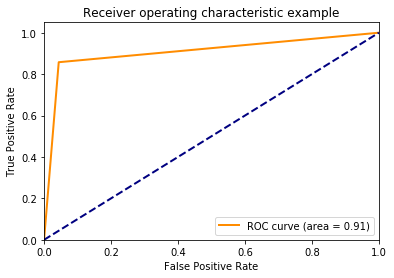

In [22]:
single_attribute_roc_curve(fprknc[1], tprknc[1], roc_aucknc[1])